In [1]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2
%config InlineBackend.figure_format = 'retina'
%reload_ext lab_black

In [2]:
import logging
import string
import sys
import os

import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import xarray as xr
from replay_trajectory_classification import ClusterlessClassifier

from src.figure_utilities import set_figure_defaults
from src.parameters import TRANSITION_TO_CATEGORY

set_figure_defaults()

## Find sleep epochs and previous run epochs

In [5]:
from src.parameters import ANIMALS
from loren_frank_data_processing import make_epochs_dataframe

epoch_info = make_epochs_dataframe(ANIMALS)

In [6]:
epoch_info.environment.value_counts()

nan             501
WTrackA          93
TrackB           57
TrackA           51
WTrackB          48
OpenFieldA       44
LinearA          33
OpenFieldB       27
sleep             9
wtrack            6
WTrackA-fail      1
Name: environment, dtype: int64

In [46]:
sleep_epochs = epoch_info.loc[epoch_info.type == "sleep"].query("epoch > 1")
sleep_epochs

environment   type  exposure
animal day epoch                             
Cor    1   3             nan  sleep       NaN
           5             nan  sleep       NaN
       2   3             nan  sleep       NaN
           5             nan  sleep       NaN
       3   3             nan  sleep       NaN
...                      ...    ...       ...
remy   35  5           sleep  sleep       NaN
       36  3           sleep  sleep       NaN
           5           sleep  sleep       NaN
       37  3           sleep  sleep       NaN
           5           sleep  sleep       NaN

[403 rows x 3 columns]

In [61]:
previous_run_epoch_keys = (
    sleep_epochs.reset_index("epoch")
    .assign(epoch=lambda ds: ds["epoch"] - 1)
    .set_index("epoch", append=True)
    .index
)
previous_run_epochs = epoch_info.loc[previous_run_epoch_keys].query("type == 'run'")
previous_run_epochs

environment type  exposure
animal day epoch                           
Cor    1   2          TrackA  run       1.0
           4          TrackA  run       2.0
       2   2          TrackA  run       3.0
           4          TrackA  run       4.0
       3   2          TrackA  run       5.0
...                      ...  ...       ...
remy   35  4          wtrack  run       2.0
       36  2          wtrack  run       3.0
           4          wtrack  run       4.0
       37  2          wtrack  run       5.0
           4          wtrack  run       6.0

[342 rows x 3 columns]

In [62]:
sleep_epochs

environment   type  exposure
animal day epoch                             
Cor    1   3             nan  sleep       NaN
           5             nan  sleep       NaN
       2   3             nan  sleep       NaN
           5             nan  sleep       NaN
       3   3             nan  sleep       NaN
...                      ...    ...       ...
remy   35  5           sleep  sleep       NaN
       36  3           sleep  sleep       NaN
           5           sleep  sleep       NaN
       37  3           sleep  sleep       NaN
           5           sleep  sleep       NaN

[403 rows x 3 columns]

In [63]:
for name, df in epoch_info.groupby(["animal", "day"]):
    pass

In [70]:
df

environment   type  exposure
animal day epoch                             
remy   37  1           sleep  sleep       NaN
           2          wtrack    run       5.0
           3           sleep  sleep       NaN
           4          wtrack    run       6.0
           5           sleep  sleep       NaN

In [78]:
(df.iloc[1:].type == "sleep")

animal  day  epoch
remy    37   2        False
             3         True
             4        False
             5         True
Name: type, dtype: bool

In [82]:
(df.iloc[:-1].type == "run")

animal  day  epoch
remy    37   1        False
             2         True
             3        False
             4         True
Name: type, dtype: bool

In [81]:
((df.iloc[1:].type == "sleep") & (df.iloc[:-1].type == "run").values)

animal  day  epoch
remy    37   2        False
             3         True
             4        False
             5         True
Name: type, dtype: bool

In [96]:
is_sleep_after_run = (df.iloc[1:].type == "sleep") & (df.iloc[:-1].type == "run").values

df.iloc[np.nonzero(is_sleep_after_run)[0] + 1]

environment   type  exposure
animal day epoch                             
remy   37  3           sleep  sleep       NaN
           5           sleep  sleep       NaN

In [97]:
df.iloc[np.nonzero(is_sleep_after_run)[0]]

environment type  exposure
animal day epoch                           
remy   37  2          wtrack  run       5.0
           4          wtrack  run       6.0

In [111]:
import itertools

sleep_epoch_keys = []
prev_run_epoch_keys = []

for _, df in epoch_info.groupby(["animal", "day"]):
    is_w_track = (
        df.iloc[:-1].environment.isin(
            ["TrackA", "TrackB", "WTrackA", "WTrackB", "wtrack"]
        )
    ).values

    is_sleep_after_run = (df.iloc[1:].type == "sleep") & is_w_track
    sleep_ind = np.nonzero(is_sleep_after_run)[0] + 1

    sleep_epoch_keys.append(df.iloc[sleep_ind].index)
    prev_run_epoch_keys.append(df.iloc[sleep_ind - 1].index)

sleep_epoch_keys = list(itertools.chain(*sleep_epoch_keys))
prev_run_epoch_keys = list(itertools.chain(*prev_run_epoch_keys))

In [112]:
epoch_info.loc[sleep_epoch_keys].type.value_counts()

sleep    237
Name: type, dtype: int64

In [113]:
epoch_info.loc[prev_run_epoch_keys].type.value_counts()

run    237
Name: type, dtype: int64

In [114]:
epoch_info.loc[sleep_epoch_keys]

environment   type  exposure
animal day epoch                             
Cor    1   3             nan  sleep       NaN
           5             nan  sleep       NaN
       2   3             nan  sleep       NaN
           5             nan  sleep       NaN
       3   3             nan  sleep       NaN
...                      ...    ...       ...
remy   35  5           sleep  sleep       NaN
       36  3           sleep  sleep       NaN
           5           sleep  sleep       NaN
       37  3           sleep  sleep       NaN
           5           sleep  sleep       NaN

[237 rows x 3 columns]

In [115]:
epoch_info.loc[prev_run_epoch_keys].environment.value_counts()

WTrackA    80
TrackB     57
TrackA     50
WTrackB    44
wtrack      6
Name: environment, dtype: int64

In [123]:
sleep_epoch_keys.index(("bon", 3, 3))

24

In [128]:
sleep_epoch_key, prev_run_epoch_key = sleep_epoch_keys[24], prev_run_epoch_keys[24]
sleep_epoch_key, prev_run_epoch_key

(('bon', 3, 3), ('bon', 3, 2))

## Load data

From run:

In [130]:
from src.parameters import PROCESSED_DATA_DIR

data_type, dim = "clusterless", "1D"
animal, day, epoch = prev_run_epoch_key

model_name = os.path.join(
    PROCESSED_DATA_DIR, f"{animal}_{day:02}_{epoch:02}_{data_type}_{dim}_model.pkl"
)
classifier = ClusterlessClassifier.load_model(model_name)
classifier

ClusterlessClassifier(continuous_transition_types=[['random_walk', 'uniform',
                                                    'identity'],
                                                   ['uniform', 'uniform',
                                                    'uniform'],
                                                   ['random_walk', 'uniform',
                                                    'identity']],
                      discrete_transition_diag=0.98,
                      discrete_transition_type='strong_diagonal',
                      infer_track_interior=True,
                      initial_conditions_type='uniform_on_track',
                      model=<class 'replay_trajectory_classification.misc.NumbaKDE'>,
                      model_kwargs={'bandwidth': array([24., 24., 24., 24.,  6.,  6.])},
                      movement_var=6.0,
                      occupancy_kwargs={'bandwidth': array([24., 24., 24., 24.,  6.,  6.])},
                      occupancy_m

From sleep:

In [139]:
from loren_frank_data_processing.position import _get_pos_dataframe

position_info = _get_pos_dataframe(sleep_epoch_key, ANIMALS)
position_info

,x_position,y_position,head_direction,speed
time,,,,
01:18:48.629500,124.65,109.80,2.378413,20.719210
01:18:48.662900,124.65,109.80,2.283154,20.719210
01:18:48.696200,124.65,110.70,2.330559,20.389523
01:18:48.729600,123.75,112.95,2.356194,19.564882
01:18:48.763000,122.40,115.20,2.356194,18.463921
...,...,...,...,...
01:31:30.853100,135.00,86.40,0.394791,0.225597
01:31:30.886500,135.00,86.40,0.394791,0.225759
01:31:30.919900,135.00,86.40,0.394791,0.226220


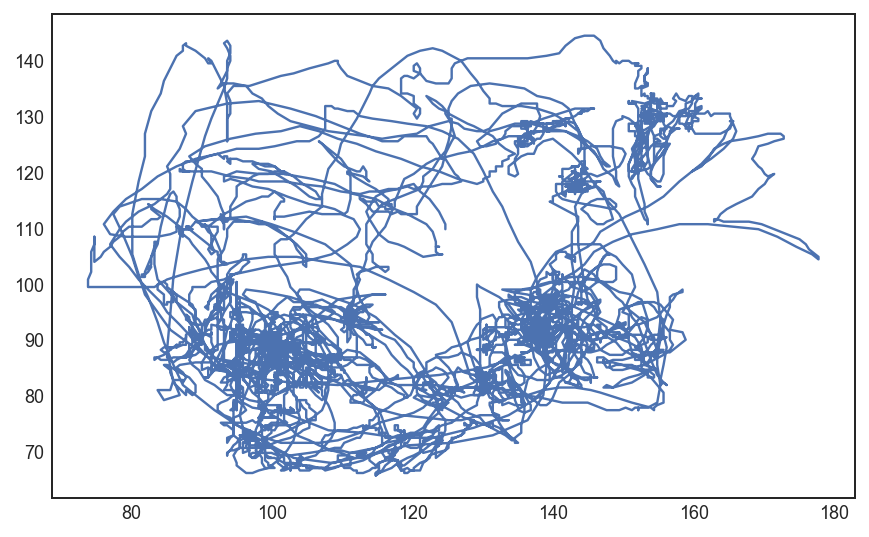

In [140]:
plt.plot(position_info.x_position, position_info.y_position)

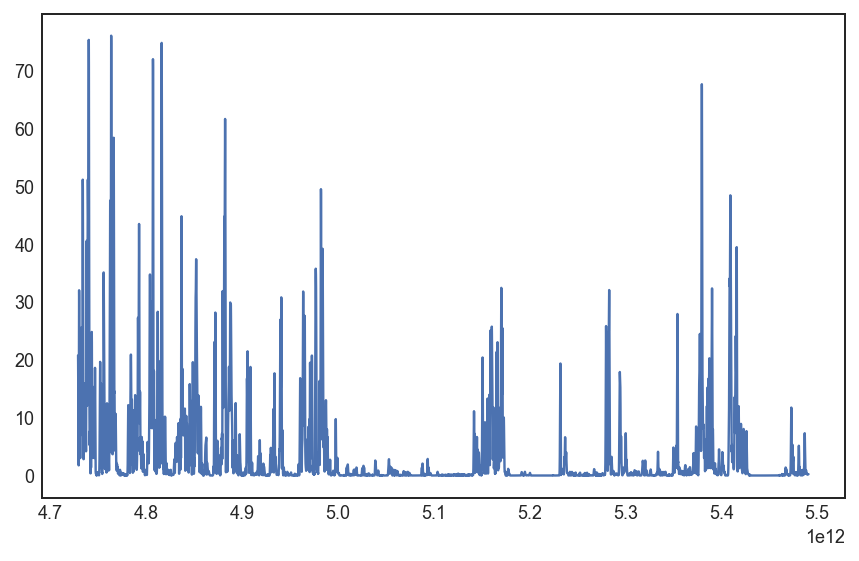

In [141]:
plt.plot(position_info.speed)

In [147]:
position_info = position_info.resample("2ms").mean().interpolate("linear")
position_info.loc[position_info.speed < 0, "speed"] = 0.0

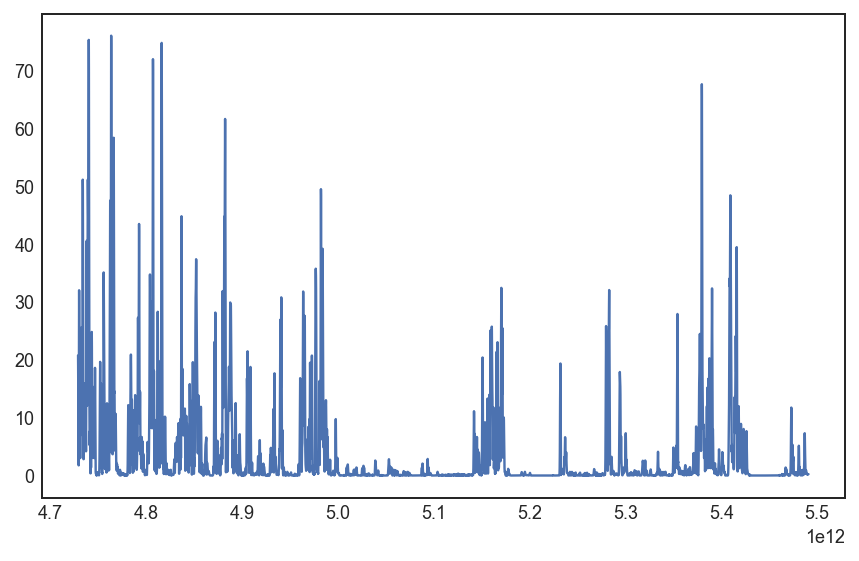

In [148]:
plt.plot(position_info.speed)

In [180]:
import numpy as np
import pandas as pd
from scipy.signal import filtfilt

from loren_frank_data_processing import (
    get_all_multiunit_indicators,
    get_all_spike_indicators,
    get_interpolated_position_dataframe,
    get_LFPs,
    get_trial_time,
    make_neuron_dataframe,
    make_tetrode_dataframe,
    get_position_dataframe,
)
from loren_frank_data_processing.tetrodes import get_trial_time
from ripple_detection import Kay_ripple_detector, get_multiunit_population_firing_rate
from ripple_detection.core import _get_ripplefilter_kernel

from src.parameters import _BRAIN_AREAS, _MARKS, ANIMALS, SAMPLING_FREQUENCY
from src.load_data import filter_ripple_band


def get_sleep_interpolated_position_info(
    epoch_key, animals, time_function=get_trial_time
):
    time = time_function(epoch_key, ANIMALS)
    position_df = get_position_dataframe(epoch_key, animals, skip_linearization=True)
    new_index = pd.Index(
        np.unique(np.concatenate((position_df.index, time))), name="time"
    )
    position_df = (
        position_df.reindex(index=new_index)
        .interpolate(method="linear")
        .reindex(index=time)
    )

    position_df.loc[position_df.speed < 0, "speed"] = 0.0

    return position_df


def get_sleep_ripple_times(epoch_key, brain_areas=["CA1", "CA2", "CA3"]):
    position_info = get_sleep_interpolated_position_info(epoch_key, ANIMALS).dropna(
        subset=["speed"]
    )
    speed = position_info["speed"]
    time = position_info.index
    tetrode_info = make_tetrode_dataframe(ANIMALS).xs(epoch_key, drop_level=False)
    if ~np.all(np.isnan(tetrode_info.validripple.astype(float))):
        tetrode_keys = tetrode_info.loc[(tetrode_info.validripple == 1)].index
    else:
        is_brain_areas = tetrode_info.area.astype(str).str.upper().isin(brain_areas)
        tetrode_keys = tetrode_info.loc[is_brain_areas].index

    lfps = get_LFPs(tetrode_keys, ANIMALS).reindex(time)
    ripple_filtered_lfps = pd.DataFrame(
        np.stack(
            [
                filter_ripple_band(lfps.values[:, ind], sampling_frequency=1500)
                for ind in np.arange(lfps.shape[1])
            ],
            axis=1,
        ),
        index=lfps.index,
    )

    ripple_times = Kay_ripple_detector(
        time,
        lfps.values,
        speed.values,
        sampling_frequency=1500,
        zscore_threshold=2.0,
        close_ripple_threshold=np.timedelta64(0, "ms"),
        minimum_duration=np.timedelta64(15, "ms"),
    )

    return ripple_times, ripple_filtered_lfps, lfps

In [173]:
ripple_times, ripple_filtered_lfps, lfps = get_sleep_ripple_times(sleep_epoch_key)

In [183]:
def load_sleep_data(epoch_key, brain_areas=None):

    if brain_areas is None:
        brain_areas = _BRAIN_AREAS

    time = get_trial_time(epoch_key, ANIMALS)
    time = (
        pd.Series(np.ones_like(time, dtype=np.float), index=time)
        .resample("2ms")
        .mean()
        .index
    )

    def _time_function(*args, **kwargs):
        return time

    position_info = get_sleep_interpolated_position_info(
        epoch_key, ANIMALS, _time_function
    ).dropna(subset=["speed"])

    time = position_info.index

    tetrode_info = make_tetrode_dataframe(ANIMALS, epoch_key=epoch_key)
    is_brain_areas = tetrode_info.area.astype(str).str.upper().isin(brain_areas)
    tetrode_keys = tetrode_info.loc[is_brain_areas].index
    lfps = get_LFPs(tetrode_keys, ANIMALS)
    lfps = lfps.resample("2ms").mean().fillna(method="pad").reindex(time)

    try:
        neuron_info = make_neuron_dataframe(ANIMALS).xs(epoch_key, drop_level=False)
        neuron_info = neuron_info.loc[
            (neuron_info.numspikes > 100)
            & neuron_info.area.isin(brain_areas)
            & (neuron_info.type == "principal")
        ]
        spikes = get_all_spike_indicators(
            neuron_info.index, ANIMALS, _time_function
        ).reindex(time)
    except KeyError:
        spikes = None

    tetrode_info = tetrode_info.loc[is_brain_areas]
    multiunit = (
        get_all_multiunit_indicators(tetrode_info.index, ANIMALS, _time_function)
        .sel(features=_MARKS)
        .reindex({"time": time})
    )
    multiunit_spikes = (np.any(~np.isnan(multiunit.values), axis=1)).astype(np.float)
    multiunit_firing_rate = pd.DataFrame(
        get_multiunit_population_firing_rate(multiunit_spikes, SAMPLING_FREQUENCY),
        index=time,
        columns=["firing_rate"],
    )

    ripple_times, ripple_filtered_lfps, ripple_lfps = get_sleep_ripple_times(epoch_key)

    ripple_times = ripple_times.assign(
        duration=lambda df: (df.end_time - df.start_time).dt.total_seconds()
    )

    return {
        "position_info": position_info,
        "ripple_times": ripple_times,
        "spikes": spikes,
        "multiunit": multiunit,
        "lfps": lfps,
        "tetrode_info": tetrode_info,
        "ripple_filtered_lfps": ripple_filtered_lfps,
        "ripple_lfps": ripple_lfps,
        "multiunit_firing_rate": multiunit_firing_rate,
        "sampling_frequency": SAMPLING_FREQUENCY,
    }

In [184]:
data = load_sleep_data(sleep_epoch_key, brain_areas=None)
data.keys()

dict_keys(['position_info', 'ripple_times', 'spikes', 'multiunit', 'lfps', 'tetrode_info', 'ripple_filtered_lfps', 'ripple_lfps', 'multiunit_firing_rate', 'sampling_frequency'])

In [ ]:
from src.parameters import TRANSITION_TO_CATEGORY
import xarray as xr
import pandas as pd
from scipy.ndimage import label
from tqdm.auto import tqdm

# Decode
is_test = data['position_info'].speed <= 4

test_groups = pd.DataFrame(
    {'test_groups': label(is_test.values)[0]}, index=is_test.index)
immobility_results = []
for _, df in tqdm(test_groups.loc[is_test].groupby('test_groups'),
                  desc='immobility'):
    start_time, end_time = df.iloc[0].name, df.iloc[-1].name
    test_multiunit = data['multiunit'].sel(
        time=slice(start_time, end_time))
    immobility_results.append(
        classifier.predict(test_multiunit, time=test_multiunit.time))

immobility_results = xr.concat(immobility_results, dim='time')

results = [(immobility_results
            .sel(time=slice(df.start_time, df.end_time))
            .assign_coords(time=lambda ds: ds.time - ds.time[0]))
           for _, df in data['ripple_times'].iterrows()]

results = (xr.concat(results, dim=data['ripple_times'].index)
           .assign_coords(state=lambda ds: ds.state.to_index()
                          .map(TRANSITION_TO_CATEGORY)))